# Section 2.2.2 PRCC and Section 2.2.3 Sobol Indices

In [ ]:
using QuasiMonteCarlo, Distributions, Random, Statistics, Plots, LaTeXStrings, Colors, OrdinaryDiffEq, LinearAlgebra, InvertedIndices, StatsBase, DifferentialEquations, GlobalSensitivity

# Example 3.4
We compute the PRCCs and Sobol total effect indices of the effective reproduction number $\mathcal{R}_{t}(t)$ of the Ebola virus disease (EVD)
\begin{equation}
\mathcal{R}_{t}(t) = \mathcal{R}_0(t) \frac{S(t)}{N(t)},
\end{equation}
where the basic reproduction number $\mathcal{R}_0(t)$
\begin{equation}
\mathcal{R}_0(t) = \underbrace{\frac{\beta(t) \left(\gamma_H + \kappa\right)}{\gamma_H \eta(t) + \gamma \left(\gamma_H + \kappa\right)}}_{\mathcal{R}_C} + \underbrace{\frac{\eta(t) \theta(t)}{\gamma_H \eta(t) + \gamma \left(\gamma_H + \kappa\right)}}_{\mathcal{R}_H} + \underbrace{\frac{\varphi(t)\left(\gamma_H \delta_H \eta(t) + \gamma \delta \left(\gamma_H + \kappa\right)\right)}{b(t) \left(\gamma_H \eta(t) + \gamma \left(\gamma_H + \kappa\right)\right)}}_{\mathcal{R}_F}
\end{equation}
w.r.t. the time-variant parameters $\beta(t), \theta(t), \varphi(t), \eta(t), b(t)$ and the time-invariant parameters $\gamma, \gamma_H, \delta, \delta_H, \kappa$.
The time-dependent control parameters $\beta(t), \theta(t), \varphi(t), \eta(t)$ and $b(t)$ change gradually in time, once the intervention strategy has been introduced $T_{Intervention}$. The control parameters gradually change from $q$ to $\tilde{q}$ according to
\begin{equation}
    q(t)=
    \begin{cases}
      q, & \text{for } t<T_{Intervention}\\
      \tilde{q}+(q-\tilde{q})e^{-k_{q}(t-T_{Intervention})} & \text{for } t \geq T_{Intervention},
    \end{cases}
\end{equation}
where $k_{q}$ indicates how fast the transition from the initial value $q$ to the target value $\tilde{q}$ of the time-dependent control parameters occurs. The time-dependent control parameters reach their mean value $(q+\tilde{q})/2$ at time $T_{Inter} + t_q$, where $t_q=\ln(2)/k_q$. The intervention strategies are introduced after $T_{Intervention}=25$ weeks. And we compute the PRCCs and Sobols total effect indices at $t=0, t=27$ and $t=60$ weeks.

## 0. Utilities

##### Implementation of a Latin Hypercube Sampling scheme for a uniform distribution

In [66]:
"""
Generates a Latin Hypercube sampling plan

    Inputs:
        p - number of dimensions
        N - number of sample points
        low - lower boundary 
        high - upper boundary
    Output:
        Q - Latin Hypercube Sampling plan, Q ∈ R^N×p
"""
function latin_hypercube_uniform(p, N, low=0, high=1)
    # inverse cdf for uniform distribution
    cdf_inverse_uniform(p,a,b) = a+p*(b-a)
    
    # cast to array if length is one
    if length(low) == 1
        low = ones(p,1).*low
        high = ones(p,1).*high
    end
    
    # assert that low values are lower than high values, otherwise throw error
    if any(x->x<0, high.-low)
        error("Some upper boundary values are lower than the lower boundary values")
    end
    
    # Pre-alloc memory
    Q = zeros((N,p))
    # width of the subintervals in cdf function
    Δ = 1.0/N
    
    # small number to avoid sampling the boundaries twice
    # open intervall on lower and closed intervall on upper boundary
    # ! in the first intervall both boundaries are closed !
    # ! i commented it out since this small additional perturbation is to big 
    # ! if our stepsize Δ is very small due to a high number of samples
    # ! error occured in unit test
#     ϵ = sqrt(eps(Float32))
    for i in 1:p
        lower, upper = (0.0, Δ)
        for j in 1:N
            q_j = rand(Uniform(lower,upper))
            Q[j,i] = cdf_inverse_uniform(q_j,low[i],high[i])
            lower += Δ
            upper += Δ
#             if j == 1
#                 lower += (Δ+ϵ)
#                 upper += Δ
#             else
#                 lower += Δ
#                 upper += Δ
#             end
        end
    end
    # permutate the vector
    for i in 1:p
        Q[:,i] = shuffle(Q[:,i])
    end
    Q
end;

##### Ebola Spread Model

In [67]:
function Ebola!(du,u,p,t)
    β,θ,ϕ,η,b,γ,γₕ,δ,δₕ,κ,α = p
    S,E,I,R,H,D,C,B = u
    N = S+E+I+R
    
    λ = β*(I/N)+θ*(H/N)+ϕ*(D/N) # force of infection
    du[1] = S′ = -λ*S
    du[2] = E′ = λ*S-α*E
    du[3] = I′ = α*E-(γ+η)*I+κ*H
    du[4] = R′ = (1-δ)*γ*I+(1-δₕ)*γₕ*H
    du[5] = H′ = η*I-(γₕ+κ)*H
    du[6] = D′ = δ*γ*I+δₕ*γₕ*H-b*D
    du[7] = C′ = α*E
    du[8] = B′ = b*D
end;

##### Baseline values and parameter ranges of the parameters that influence disease spread.

In [68]:
# Baseline values for the parameters of the Ebola spread model (for monotonicity plot)
β = 0.532           # [1/week] Transmission rate in the community beforContinuousCallbacktervention
θ = 0.328           # [1/week] Transmission rate in hospitals before intervention
ϕ = 2.104           # [1/week] Transmission rate at funerals before intervention
α = 1.0/(10.0/7.0)  # [1/week] 1/(Mean duration of the incubation period)
γ =  1.0/(10.4/7.0) # [1/week] 1/(Mean duration of the infection)
γₕ = 1.0/(4.6/7.0)  # [1/week] 1/(Average permanence in the hospital)
δ = 0.73            # []       Case fatality rate in the community
δₕ = 0.61           # []       Case fatality ratio in hospitals
η = 1.0/(4.8/7.0)   # [1/week] 1/(Mean time from symptoms onset to hospitalization) before intervention
κ = 0.0025          # [1/week] Hospital leaving rate
b = 1.0/(5.4/7.0)   # [1/week] 1/(Mean time from death to burial) before intervention

# Lower and upper boundaries for the investigated parameter ranges
β_lo, β_up = 0.35, 0.575
θ_lo, θ_up = 0.1, 0.48
ϕ_lo, ϕ_up = 1.402, 2.475
α_lo, α_up = 1.0/(10.5/7.0), 1.0/(9.5/7.0)
γ_lo, γ_up = 1.0/(10.5/7.0), 1.0/(9.5/7.0)
γₕ_lo, γₕ_up = 1.0/(4.9/7.0), 1.0/(4.4/7.0)
δ_lo, δ_up = 0.69, 0.73
δₕ_lo, δₕ_up = 0.52, 0.64
η_lo, η_up = 1.0/(5.3/7.0), 1.0/(4.8/7.0)
κ_lo, κ_up = 0.0022, 0.0028
b_lo, b_up = 1.0/(6.6/7.0), 1.0/(4.0/7.0);

##### Initial conditions

In [69]:
# Initial values for the system
S₀ = 2.2e7 # Susceptible
E₀ = 3.42  # Exposed
I₀ = 2.31 # Infectious
R₀ = 0.0 # Removed
H₀ = 0.1 # Hospitalized
D₀ = 4.25 # Dead
C₀ = 0.0 # Cumulative number of infected cases
B₀ = 0.0 # Cumulative number of burials
N₀ = S₀+E₀+I₀+R₀; # total population in the community

##### Vector of baseline values, initial conditions and boundaries of the paramter domain $\mathbf{Q}$.

In [70]:
u₀ = [S₀,E₀,I₀,R₀,H₀,D₀,C₀,B₀]; # vector of initial conditions
𝐐_bounds = [β_lo β_up;
            θ_lo θ_up;
            ϕ_lo ϕ_up;
            η_lo η_up;
            b_lo b_up;
            γ_lo γ_up;
            γₕ_lo γₕ_up;
            δ_lo δ_up;
            δₕ_lo δₕ_up;
            κ_lo κ_up;
            α_lo α_up];

## 1. Compute the partial rank correlation coefficients (PRCCs)
##### Function to compute the PCCs or PRCCs

In [71]:
"""
Function to compute the PCCs or PRCCs
    Inputs:
        Q - Samping plan, Q ∈ R^N×p (each row is a sampling point)
        y - Realization of the QoI for the associated sampling points in Q, y ∈ R^N×1
        ranked - ranked=true ⟶ PRCC, default is ranked=false ⟶ PCC
    Output:
        ρ - Vector with the PCC or PRCC for each parameter, ρ ∈ R^p×1
"""
function partial_corrcoef(Q,y,ranked=false)
    Q = copy(Q)
    y = copy(y)
    N = size(Q)[1] # get number of samples
    p = size(Q)[2] # get number of parameters
    
    # extra part for PRCC
    if ranked
        y = ordinalrank(y)
        Qtmp = copy(Q)
        for i in 1:p
            Q[:,i] = ordinalrank(Qtmp[:,i])
        end
    end
    
    Q = hcat(Q,ones(N,1)) # add ones for bias
    
    ρ = zeros(p,1) # preallocate output for PCCs or PRCCs
    Q★ = zeros(N,p)
    Y★ = zeros(N,p)
    
    # since we use julia we do not need to vectorize
    # our code for speed
    # iterate over all parameters
    for i in 1:p
        wq★ = Q[:,Not(i)]\Q[:,i]
        wy★ = Q[:,Not(i)]\y
        # iterate over all samples
        for j in 1:N
            # calculate residuals
            q★ = Q[j,i] - dot(wq★,Q[j,Not(i)])
            y★ = y[j] - dot(wy★,Q[j,Not(i)])
            Q★[j,i] = q★
            Y★[j,i] = y★
        end
    end
    
    # calculate the sample correlation coefficient
    # for each input factor
    for i in 1:p
       ρ[i] =  (dot(Q★[:,i],Y★[:,i]))/(sqrt(dot(Q★[:,i],Q★[:,i]))
                                      *sqrt(dot(Y★[:,i],Y★[:,i])))
    end
    
    return ρ
    
end;


##### Callback function to introduce time-dependent parameters

In [72]:
# Using a callback functions the ODE solver saves every timestep within the callback twice,
# thus we need an extra if-case to provide unique timesteps (if-case in next code cell)


# Sample the parameter domain 𝐐 using the latin hypercube sampling scheme
N_ = 1000::Int
𝐐 = latin_hypercube_uniform(11,N_,𝐐_bounds[:,1],𝐐_bounds[:,2]);
counter_N = 1
T_intervention = 25.0
Δ = 0.1
tspan=(0.0,60)
times = [i for i in T_intervention:Δ:tspan[2]]
condition(u,t,integrator) = t ∈ times
function affect!(integrator)
    if integrator.t == T_intervention
        # save parameter values before intervention
        global β_ = integrator.p[1]
        global θ_ = integrator.p[2]
        global ϕ_ = integrator.p[3]
        global η_ = integrator.p[4]
        global b_ = integrator.p[5]
        
        # baseline values for the intervention parameters
        global β_hat_ = integrator.p[1] - integrator.p[1]*0.05
        global θ_hat_ = integrator.p[2] - integrator.p[2]*0.71
        global ϕ_hat_ = integrator.p[3] - integrator.p[3]*0.47
        global η_hat_ = integrator.p[4] + integrator.p[4]*0.17
        global b_hat_ = integrator.p[5] + integrator.p[5]*0.10
        
        global counter_num_t_ = 1 # counter to index the current timestep
        global counter_N
    end
    
    # time to achieve (param + param_hat)/2
    t_β = 12.5/7.0
    t_θ = 11.1/7.0
    t_ϕ = 10.3/7.0
    t_η = 27.1/7.0
    t_b = 21.2/7.0;
    
    # k_param specifiecs how fast the transition from param to param_hat occurs
    k_β = log(2)/t_β
    k_θ = log(2)/t_θ
    k_ϕ = log(2)/t_ϕ
    k_η = log(2)/t_η
    k_b = log(2)/t_b
    
    integrator.p[1] = β_hat_+(β_-β_hat_)*exp(-k_β*(integrator.t-T_intervention))
    integrator.p[2] = θ_hat_+(θ_-θ_hat_)*exp(-k_θ*(integrator.t-T_intervention))
    integrator.p[3] = ϕ_hat_+(ϕ_-ϕ_hat_)*exp(-k_ϕ*(integrator.t-T_intervention))
    integrator.p[4] = η_hat_+(η_-η_hat_)*exp(-k_η*(integrator.t-T_intervention))
    integrator.p[5] = b_hat_+(b_-b_hat_)*exp(-k_b*(integrator.t-T_intervention))
    
    # Save the current value of the timevariant parameter
    P[counter_N,counter_num_t_,1] = integrator.p[1]
    P[counter_N,counter_num_t_,2] = integrator.p[2]
    P[counter_N,counter_num_t_,3] = integrator.p[3]
    P[counter_N,counter_num_t_,4] = integrator.p[4]
    P[counter_N,counter_num_t_,5] = integrator.p[5]
    counter_num_t_ += 1
end
cb = DiscreteCallback(condition,affect!);

#### Compute the QoI Y=Rₜ for each timestep and for each sampling point in $\mathbf{Q}$

In [73]:
# Preallocate Matrixes
num_t = length(collect(0:Δ:tspan[2]))::Int
Ytmp = zeros(Int(num_t))
𝐐tmp = zeros(Int(num_t),Int(size(𝐐,2)))
Y_ = zeros(Int(N_),Int(num_t))
𝐐_ = zeros(Int(N_),Int(num_t),Int(size(𝐐,2)))

# Preallocate array for timevariant parameters
num_t_P = length(collect(T_intervention:Δ:tspan[2]))
P = zeros(N_,num_t_P,5) # we have 5 timevariant parameters for N_ samples and num_t_P timesteps (time-variant after t>=T_intervention)

counter_N = 1 # counter to index the current sample number
for j in 1:size(𝐐,1)
    q = copy(𝐐[j,:])
    # Make a copy since we use inplace functions which mutate the values of q
    q_ = copy(q)
    prob = ODEProblem(Ebola!,u₀,tspan,q);
    sol = solve(prob,Tsit5(),callback=cb,tstops=times,saveat=0.1);
    
    # Get the sampling values for the parameters
    β,θ,ϕ,η,b,γ,γₕ,δ,δₕ,κ,α = q_
    # Assign the constant parameters
#     𝐐tmp[:,6:end] .= q_[6:end]'
#     𝐐_[j,:,6:end] = 𝐐tmp[:,6:end]
    # Assign the timevariantparameters before the time intervall (0,T_intervention)
    # The timevariant parameters are constant
#     𝐐_[j,1:(length(collect(0:Δ:T_intervention))),1:5] .= q_[1:5]'
    
    #     sol = solve(prob,Tsit5(),saveat=0.1);
    # Use only unique timesteps
    prev_t = Inf
    counter = 1
    counter2 = 1
    for i in 1:Int(num_t+((1/Δ)*(tspan[2]-T_intervention)+1))
        # Use only unique timesteps
        curr_t = sol.t[i]
        
        if prev_t != curr_t
            S,E,I,R = sol.u[Int(i)][1:4]
            N = S+E+I+R
            
            if sol.t[i] >= T_intervention
                β,θ,ϕ,η,b = P[j,counter2,:]
                counter2 += 1
            end
            
            # Compute the corresponding basic reproduction number R₀
            R_C = (β*(γₕ+κ))/(γₕ*η+γ*(γₕ+κ)) # secondary infections generated in the community
            R_H = (η*θ)/(γₕ*η+γ*(γₕ+κ)) # secondary infections generated in the hospitals
            R_F = (ϕ*(γₕ*δₕ*η+γ*δ*(γₕ+κ)))/(b*(γₕ*η+γ*(γₕ+κ))) # secondary infections generated at funerals
            R₀_ = R_C + R_H + R_F
            
            # Compute the QoI Rₜ effective reproduction number
            Rₜ = R₀_*(S/N)
            Ytmp[counter] = Rₜ
            counter += 1
        end
        prev_t = curr_t
    end
    Y_[j,:] = Ytmp
    counter_N += 1
end
# 𝐐_[:,length(collect(0:Δ:T_intervention)):end,1:5] = P;

##### Compute the PRCCs for the parameters

In [74]:
ρ_prcc = zeros(Int(size(𝐐,2)),num_t)
for i in 1:num_t
    ρ_prcc_tmp = partial_corrcoef(𝐐[:,1:11],Y_[:,i],true);
#     ρ_prcc_tmp = partial_corrcoef(𝐐[:,i,1:11],Y_[:,i],true);
    ρ_prcc[:,i] = ρ_prcc_tmp
end

##### Plot the PRCCs of the ten parameters that influence the disease spread
# Figure 2.16

In [1]:
# fontsize
fontsize=22
fontsize_text = 22
fonsize_label = 22
# same colors as for FSAP method
colors = [colorant"#ff9f1c",colorant"#997b66",colorant"#7b2cbf",colorant"#f15bb5",colorant"#b9faf8",colorant"#ffea00",colorant"#89b0ae",colorant"#38b000",
          colorant"#e71d36",colorant"#087e8b",colorant"#011627"]
parameter_label = reverse([L"\beta",L"\theta",L"\varphi",L"\eta",L"b",L"\gamma",L"\gamma_H",L"\delta",L"\delta_H",L"\kappa",L"\alpha"])
p1 = bar(legend=:none,ytickfontsize=fontsize,xtickfontsize=fontsize;grid=:none,framestyle=:box, orientation=:h,xlim=(-1.05,1.05),
         size=(400,400),xticks = ([-1,-0.5,0,0.5,1],[L"-1.0", L"-0.5",L"0.0",L"0.5", L"1.0"]), yticks = (collect(1:11),parameter_label))
for i in reverse(["β","θ","ϕ","η","b","γ","γₕ","δ","δₕ","κ","α"])
   print(i,"\t") 
end
p1 = annotate!([(-.72, 1, Plots.text(L"t = 0", fontsize_text, :black, :center))])
println()
for (idx, val) in enumerate(reverse(ρ_prcc[:,Int((1/Δ)*0+1)],dims=1))
    p1 = bar!([idx],[val],fillcolor=colors[idx],orientation=:h)
    print(round(val,digits=2), "\t")
end
println()
p2 = bar(yticks = (collect(1:11),parameter_label),legend=:none,ytickfontsize=fontsize,xtickfontsize=fontsize;grid=:none,framestyle=:box, orientation=:h,
         size=(400,400),xticks = ([-1,-0.5,0,0.5,1],[L"-1.0", L"-0.5",L"0.0",L"0.5", L"1.0"]),xlim=(-1.05,1.05),)
for (idx, val) in enumerate(reverse(ρ_prcc[:,Int((1/Δ)*27+1)],dims=1))
    p2 = bar!([idx],[val],fillcolor=colors[idx],orientation=:h)
    print(round(val,digits=2), "\t")
end
p2 = annotate!([(-.67, 1, Plots.text(L"t = 27", fontsize_text, :black, :center))])
println()
p3 = bar(yticks = (collect(1:11),parameter_label),legend=:none,ytickfontsize=fontsize,xtickfontsize=fontsize;grid=:none,framestyle=:box, orientation=:h,
         size=(400,400),xticks = ([-1,-0.5,0,0.5,1],[L"-1.0", L"-0.5",L"0.0",L"0.5", L"1.0"]),xlim=(-1.05,1.05),)
for (idx, val) in enumerate(reverse(ρ_prcc[:,Int((1/Δ)*60+1)],dims=1))
    p3 = bar!([idx],[val],fillcolor=colors[idx],orientation=:h)
    print(round(val,digits=2), "\t")
end
p3 = annotate!([(-.67, 1, Plots.text(L"t = 60", fontsize_text, :black, :center))])
l = @layout [a b c]
plot(p1,p2,p3;layout=l,size=(900,300))

- If the parameters are shifted in their uncertainty range, the transmission rates in the community $\beta$, in hospitals $\theta$, at funerals $\varphi$ and the case fatiliy rate in hospitals $\delta_H$ have on average a large positive bivariate monotonic correlation with the QoIs $\mathcal{G}_{\ell},\;\ell=1, 2, 3$ (i.\,e. $\mathcal{R}_t(t),\;t=0, 27, 60\;[\textrm{weeks}]$). This is in line with our expectations, as, for example, a higher transmission rate at funerals $\varphi$ will always lead to a larger reproduction number.
- The burial rate $b$ has a high inverse bivariate monotonic correlation with the QoIs $\mathcal{G}_{\ell},\;\ell=1, 2, 3$. This indicates that increasing the mean time from death to burial $b^{{-}1}$ increases the effective reproduction number $\mathcal{R}_t$.
- The model parameters $\eta, \gamma, \gamma_H, \delta, \kappa$ and $\alpha$ have very low PRCCs. This indicates that the parameters do not have a bivariate monotonic relationship with the QoIs. However it would be wrong to conclude that the parameters have no influence on the QoIs, as they could have non-monotonic dependencies with strong effects on the QoIs.
- The PRCC of the transmission rate in the community $\beta$ slightly increases and the transmission rate in hospitals $\theta$ slightly decreases in time. 

## 2. Sobol total-effect indices $S^T_i$
The computation of a total number of $2^p-1$ Sobol first-order indices $S_{i_1,\dots,i_s}\;\forall\;1 \leq i_1 < \cdots < i_s \leq p$ is too expensive when $p$ is large. 
The Sobol first-order indices might be important only in special scenarios.

The Sobol total-effect indices are implemented according to the lecture notes on Sobol indices by Parente. Similar implementations can be found in [Global Sensitivity Analysis 164-167](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184) and in [Variance based sensitivity analysis of model output 261-263](https://www.sciencedirect.com/science/article/abs/pii/S0010465509003087).
The Sobol total-effect index $S^T_i$ w.r.t. to a input parameter $Q_i$ is defined by:
\begin{equation}
S^T_i = \frac{\textrm{E}_{\mathbf{Q}_{\sim i}}\left[\textrm{Var}_{\mathbf{Q}_i}(Y|\mathbf{Q}_{\sim i})\right]}{\textrm{Var}(Y)}
\end{equation}
We utilize the Jansen's estimator for $\textrm{E}_{\mathbf{Q}_{\sim i}}\left[\textrm{Var}_{\mathbf{Q}_i}(Y|\mathbf{Q}_{\sim i})\right]$; i.e.
\begin{equation}
\frac{1}{2N}\sum_{j=1}^N \left(\mathcal{G}(A)_j - \mathcal{G}(A^{(i)}_B)_j\right)^2.
\end{equation}
The Jansen's estimator needs $N(p+1)$ model evaluations to estimate $p$ Sobol total-effect indices, where $N$ depends no the complexity of the model.
### 2.1. Implement the construction of Sobol matrices $A^{(i)}_B \in \mathbb{R}^{N \times p},\quad i = 1,\dots,p$, out of matrices $A, B \in \mathbb{R}^{N \times p}$
The matrix $A^{(i)}_B$ is a matrix that contains all columns of the matrix $A \in \mathbb{R}^{N \times p}$, where just the $i^{th}$ column of $A$ is replaced by the $i^{th}$ column of matrix $B\in \mathbb{R}^{N \times p}$. For example, $A^{(2)}_B \in \mathbb{R}^{4 \times 3}$ is
\begin{equation}
A^{(2)}_B =
\begin{pmatrix}
a_{1,1} & b_{1,2} & a_{1,3}\\
a_{2,1} & b_{2,2} & a_{2,3}\\
a_{3,1} & b_{3,2} & a_{3,3}\\
a_{4,1} & b_{4,2} & a_{4,3}
\end{pmatrix},
\end{equation}
where each $a_{j,i}, b_{j,i} \sim \mathcal{U}([0, 1]), j=1,\dots,N$ and $i=1,\dots,p$.

In [76]:
"""
Function to construct the Sobol matrices Aᵦ ∈ Rᵖˣᴺˣᵖ

    Inputs:
        A - Matrix A ∈ Rᴺˣᵖ
        B - Matrix B ∈ Rᴺˣᵖ
    Output:
        Aᵦ - Matrix that contains p Aⁱᵦ matrices
"""
function create_sobol_matrices(A,B)
    p = size(A,2) # determine the number of parameters
    Aᵦ = [copy(A) for i in 1:p]
    # We change the iᵗʰ column of the iᵗʰ matrix of Aᵦ with the iᵗʰ column of matrix B
    for i in 1:p
        Aᵦ[i][:,i] = copy(B[:,i])
    end
    return Aᵦ
end;

### 2.2. Implement the function to compute the Sobol total-effect indices $S^T_i, i=1,\dots,p$ with Jansen's estimator

In [77]:
"""
The function computes the Sobol total-effect indices Sᵀᵢ by Jansen's estimator using vectors
f(A) ∈ Rᴺ and f(Aⁱᵦ) ∈ Rᴺ, where f denotes an arbitrary real-valued function

    Inputs:
        f_A  - vector with N realizations of the quantity of interest for the parameter matrix A
        f_AB - vector with N realizations of the quantity of interest for the parameter matrix Aⁱᵦ 
    Output:
        Sᵀ - Vector of the Sobol total-effect index Sᵀ ∈ Rᵖ
"""
function compute_total_indices(f_A, f_AB)
    N = size(f_A,1)::Int # determine the number of function evaluations N
    p = size(f_AB,1)::Int # determine the number of model parameters p
    Sᵀ = Array{Float64}(undef,p) # preallocate vector of total-effects

    # calculate the Variance of Y
    VarY = Statistics.var(f_A)

    # calculate the estimator EX∼i[Varₓᵢ(Y|X∼i)] and the Sobol total-effect index
    for i in 1:p
        Es = sum(abs2.(f_A-f_AB[i]))/(2*N)
        Sᵀ[i] = Es/(VarY+eps(Float64)) # add machine epsilon to avoid dividing by zero
    end
    
    return Sᵀ
end;

### 2.3. Application to the model
(we utilize some variables defined in section 0. utilities)
#### 2.3.1. Construct the sample matrices $A, B \in \mathbb{R}^{N \times p}$ with (each) $N=1000$ samples $\mathbf{X} \sim \mathcal{U}(\mathcal{X})$ using LHS

In [78]:
𝐐_bounds; # boundaries (see 0. Utilities)

N_Sᵀ = 1000::Int # number of samples
p = 11::Int # number of input parameters

# Sample uniformly between 0 and 1 (default in latin_hypercube_uniform() function)
A_norm = latin_hypercube_uniform(p,N_Sᵀ);
B_norm = latin_hypercube_uniform(p,N_Sᵀ);
A = A_norm .* (𝐐_bounds[:,2]'.-𝐐_bounds[:,1]') .+ 𝐐_bounds[:,1]'
B = B_norm .* (𝐐_bounds[:,2]'.-𝐐_bounds[:,1]') .+ 𝐐_bounds[:,1]';

#### 2.3.2. Construct the Sobol matric Aᵦ that contains the matrices Aⁱᵦ, i = 1,…,p

In [79]:
Aᵦ = create_sobol_matrices(A,B);

#### 2.3.4. Compute vectors $\mathcal{G}(A) \in \mathbb{R}^{N}$ and $\mathcal{G}(A^{(i)}_B) \in \mathbb{R}^{N}, \quad i = 1,\dots,p$.
$\mathcal{G}$ is the effective reproduction number $R_t(t)$.

$\mathcal{G}(A): $

In [80]:
### There is a lot of boiler-plate code from computing the PRCCs ###
# preallocate variables to save the solutions
num_t = length(collect(0:Δ:tspan[2]))::Int
G_A = zeros(Int(N_Sᵀ),Int(num_t))
G_A_tmp = zeros(Int(num_t))

# Preallocate array for timevariant parameters
num_t_P = length(collect(T_intervention:Δ:tspan[2]))
P = zeros(N_Sᵀ,num_t_P,5) # we have 5 timevariant parameters for N_ samples and num_t_P timesteps (time-variant after t>=T_intervention)

counter_N = 1 # counter to index the current sample number
# Compute the solutions G(A)
for j ∈ 1:N_Sᵀ
    q = copy(A[j,:])
    # Make a copy since we use inplace functions which mutate the values of q
    q_ = copy(q)
    prob = ODEProblem(Ebola!,u₀,tspan,q);
    sol = solve(prob,Tsit5(),callback=cb,tstops=times,saveat=0.1);  
    
    # Get the sampling values for the parameters
    β,θ,ϕ,η,b,γ,γₕ,δ,δₕ,κ,α = q_
    
    # Use only unique timesteps
    prev_t = Inf
    counter = 1
    counter2 = 1
    for i in 1:Int(num_t+((1/Δ)*(tspan[2]-T_intervention)+1))
        # Use only unique timesteps
        curr_t = sol.t[i]
        
        if prev_t != curr_t
            S,E,I,R = sol.u[Int(i)][1:4]
            N = S+E+I+R
            
            if sol.t[i] >= T_intervention
                β,θ,ϕ,η,b = P[j,counter2,:]
                counter2 += 1
            end
            
            # Compute the corresponding basic reproduction number R₀
            R_C = (β*(γₕ+κ))/(γₕ*η+γ*(γₕ+κ)) # secondary infections generated in the community
            R_H = (η*θ)/(γₕ*η+γ*(γₕ+κ)) # secondary infections generated in the hospitals
            R_F = (ϕ*(γₕ*δₕ*η+γ*δ*(γₕ+κ)))/(b*(γₕ*η+γ*(γₕ+κ))) # secondary infections generated at funerals
            R₀_ = R_C + R_H + R_F
            
            # Compute the QoI Rₜ effective reproduction number
            Rₜ = R₀_*(S/N)
            G_A_tmp[counter] = Rₜ
            counter += 1
        end
        prev_t = curr_t
    end
    G_A[j,:] = copy(G_A_tmp)
    counter_N += 1 
end

$\mathcal{G}(A^{(i)}_B), \forall i=1,\dots,p: $

In [ ]:
### There is a lot of boiler-plate code from computing the PRCCs ###
# preallocate variables to save the solutions
num_t = length(collect(0:Δ:tspan[2]))::Int
G_AB = [Array{Float64}(undef,Int(N_Sᵀ),Int(num_t)) for _ in 1:p]
G_AB_ = zeros(Int(N_Sᵀ),Int(num_t))
G_AB_tmp = zeros(Int(num_t))

# Preallocate array for timevariant parameters
num_t_P = length(collect(T_intervention:Δ:tspan[2]))

for ii ∈ 1:p
    P = zeros(N_Sᵀ,num_t_P,5) # we have 5 timevariant parameters for N_ samples and num_t_P timesteps (time-variant after t>=T_intervention)

    counter_N = 1 # counter to index the current sample number
    # Compute the solutions G(A)
    for j ∈ 1:N_Sᵀ
        q = copy(Aᵦ[ii][j,:])
        # Make a copy since we use inplace functions which mutate the values of q
        q_ = copy(q)
        prob = ODEProblem(Ebola!,u₀,tspan,q);
        sol = solve(prob,Tsit5(),callback=cb,tstops=times,saveat=0.1);  

        # Get the sampling values for the parameters
        β,θ,ϕ,η,b,γ,γₕ,δ,δₕ,κ,α = q_

        # Use only unique timesteps
        prev_t = Inf
        counter = 1
        counter2 = 1
        for i in 1:Int(num_t+((1/Δ)*(tspan[2]-T_intervention)+1))
            # Use only unique timesteps
            curr_t = sol.t[i]

            if prev_t != curr_t
                S,E,I,R = sol.u[Int(i)][1:4]
                N = S+E+I+R

                if sol.t[i] >= T_intervention
                    β,θ,ϕ,η,b = P[j,counter2,:]
                    counter2 += 1
                end

                # Compute the corresponding basic reproduction number R₀
                R_C = (β*(γₕ+κ))/(γₕ*η+γ*(γₕ+κ)) # secondary infections generated in the community
                R_H = (η*θ)/(γₕ*η+γ*(γₕ+κ)) # secondary infections generated in the hospitals
                R_F = (ϕ*(γₕ*δₕ*η+γ*δ*(γₕ+κ)))/(b*(γₕ*η+γ*(γₕ+κ))) # secondary infections generated at funerals
                R₀_ = R_C + R_H + R_F

                # Compute the QoI Rₜ effective reproduction number
                Rₜ = R₀_*(S/N)
                G_AB_tmp[counter] = Rₜ
                counter += 1
            end
            prev_t = curr_t
        end
        G_AB_[j,:] = copy(G_AB_tmp)
        counter_N += 1 
    end
    G_AB[ii] = copy(G_AB_)
    println("parameter: ", ii, " done...")
end

#### We compute the Sobol total-effect indices at $t=0$, $t=27$ and $t=60$ weeks.

In [83]:
# Filter the arrays for the solution of the corresponding timepoints
G_A_timepoints = Array{Array{Float64},1}(undef,3)
G_AB_timepoints = [Array{Float64}(undef,N_Sᵀ,3) for _ in 1:p]
for (idx, val) in enumerate([0,27,60])
    G_A_timepoints[idx] = G_A[:,Int((1/Δ)*val+1)]
end
for i_p in 1:p
    for (idx, val) in enumerate([0,27,60])
        G_AB_timepoints[i_p][:,idx] = G_AB[i_p][:,Int((1/Δ)*val+1)]
    end
end

In [84]:
Sᵀ = Array{Array{Float64},1}(undef,3) # init array of array with sensitivity indices
G_AB_t = Array{Array{Float64},1}(undef,p)
for (idx, val) in enumerate([0,27,60])
    G_A_t = copy(G_A_timepoints[idx])
    for i in 1:p
        G_AB_t[i] = G_AB_timepoints[i][:,idx]
    end
    Sᵀ[idx] = compute_total_indices(G_A_t,G_AB_t)
end

# Figure 2.17

In [3]:
# fontsize
fontsize=22
fontsize_text = 22
fonsize_label = 22
colors = [colorant"#ff9f1c",colorant"#997b66",colorant"#7b2cbf",colorant"#f15bb5",colorant"#b9faf8",colorant"#ffea00",colorant"#89b0ae",colorant"#38b000",
          colorant"#e71d36",colorant"#087e8b",colorant"#011627"]
parameter_label = reverse([L"\beta",L"\theta",L"\varphi",L"\eta",L"b",L"\gamma",L"\gamma_H",L"\delta",L"\delta_H",L"\kappa",L"\alpha"])
p4 = bar(legend=:none,ytickfontsize=fontsize,xtickfontsize=fontsize;grid=:none,framestyle=:box, orientation=:h,
         xlim=(-0.01,1.035),size=(400,400),xticks = ([0,0.25,0.5,0.75,1],[L"0.0", L"0.25",L"0.5",L"0.75", L"1.0"]),
         yticks = (collect(1:11),parameter_label),)
for i in reverse(["β","θ","ϕ","η","b","γ","γₕ","δ","δₕ","κ","α"])
   print(i,"\t") 
end
println()
for (idx, val) in enumerate(reverse(Sᵀ[1]))
    p4 = bar!([idx],[val],fillcolor=colors[idx],orientation=:h)
    print(round(val,digits=2), "\t")
end
p4 = annotate!([(0.9, 1., Plots.text(L"t = 0", fontsize_text, :black, :center))])
println()

p5 = bar(legend=:none,ytickfontsize=fontsize,xtickfontsize=fontsize;grid=:none,framestyle=:box, orientation=:h,
         xlim=(-0.01,1.035),size=(400,400), xticks = ([0,0.25,0.5,0.75,1],[L"0.0", L"0.25",L"0.5",L"0.75", L"1.0"]),
         yticks = (collect(1:11),parameter_label),)
for (idx, val) in enumerate(reverse(Sᵀ[2]))
    p5 = bar!([idx],[val],fillcolor=colors[idx],orientation=:h)
    print(round(val,digits=2), "\t")
end
p5 = annotate!([(0.875, 1, Plots.text(L"t = 27", fontsize_text, :black, :center))])
println()

p6 = bar(legend=:none,ytickfontsize=fontsize,xtickfontsize=fontsize;grid=:none,framestyle=:box, orientation=:h,
         xlim=(-0.01,1.035),size=(400,400),xticks = ([0,0.25,0.5,0.75,1],[L"0.0", L"0.25",L"0.5",L"0.75", L"1.0"]),
         yticks = (collect(1:11),parameter_label))
for (idx, val) in enumerate(reverse(Sᵀ[3]))
    p6 = bar!([idx],[val],fillcolor=colors[idx],orientation=:h)
    print(round(val,digits=2), "\t")
end
p6 = annotate!([(0.875, 1, Plots.text(L"t = 60", fontsize_text, :black, :center))])
l = @layout [a b c]
plot(p4,p5,p6;layout=l,size=(900,300))

## Interpret the Sobol total-effect indices and complement them with the PRCCs

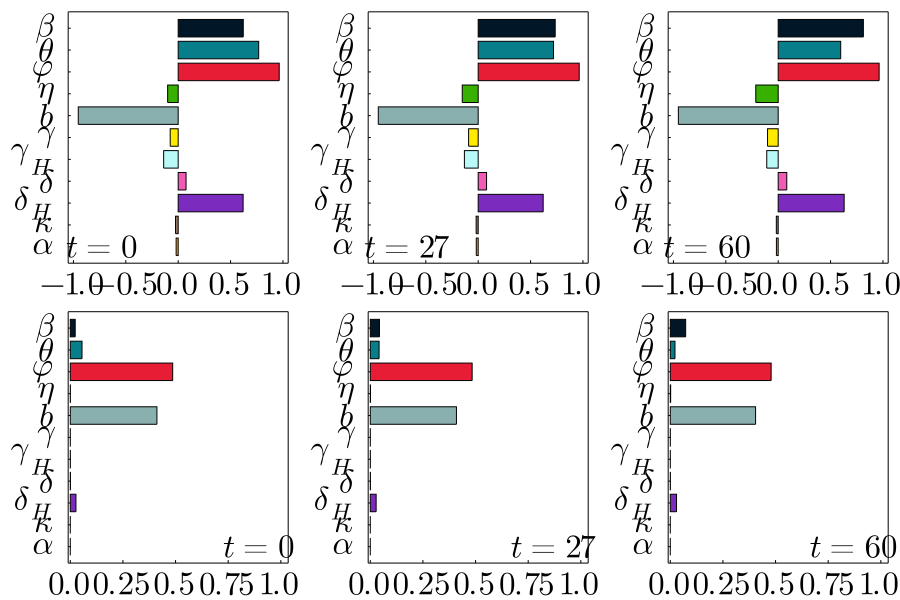

In [112]:
ll = @layout [a b c ; c d e]
plot(p1,p2,p3,p4,p5,p6; layout=ll,size=(900,600))

The results of the Sobol total-effect indices and the PRCCs should not be compared, but rather complemented, as they both measure a different type of sensitivity.
- The burial rate $b$ has high Sobol total effect indices, from which we can conclude that the parameter has a large influence on the QoIs. However, if our knowledge is based solely on the Sobol total-effect indices, we do not know whether the parameter $b$ is positively or negatively correlated with the QoIs, since the sign of contribution is removed due to the variance-based approach. But as the associated PRCCs ave a high negative value, we can infer that the parameter $b$ is inversely correlated and has a high influence on the QoIs.
- The variation of the input factors $\varphi$ and $b$ leads to the most significant variance in the QoIs, as the Sobol total-effect indices have the largest values. And since the associated PRCCs have high absolute values, we can deduce with a high degree of certainty from the sign of the PRCCs wheather the QoIs will increase or decrease if we increase or decrease the parameters.
- The low PRCCs for the parameters $\eta, \gamma, \gamma_H, \delta, \kappa$ and $\alpha$ indicate that the parameters have a non-monotonic relationship with the QoIs. Further, the corresponding low values of the Sobol total-effect indices show that these non-monotonic parameters have practically no influence on the QoIs.
- The PRCCs for the parameters $\beta, \theta$ and $\delta_H$ assume a fairly high bivariate monotonic correltation between the parameters and the QoIs. However, if we consider the Sobol total-effect indices, we observe that the relative contribution of the parameters to the variance in the QoIs rather small.

## Quantify the amount of interaction between the variables
The sum of the total effect is greater than one; i.e. $\sum_{i=1}^{n} S^T_i \geq 1$.
This is due to the fact that the interaction between e.g. $Q_i$ and $Q_j$ $i \neq j$ is counted in both $S^T_i$ and $S^T_j$. The sum is only equal to one (part of the first-order effects) if the model is purely additive, s.t. there are no interaction effects between the parameters. Therefore, we divide the difference of $\Delta = \sum_{i=1}^{n} S^T_i - 1$ (absolute amount of interaction) through the sum of the total effects, this results approximately in (relative) amount of interaction between the model parameters.
$$\text{Interaction} = \frac{\Delta}{\sum_{i=1}^{n} S^T_i}$$

In [4]:
Interaction_G_0_weeks = (sum(Sᵀ[1])-1)/sum(Sᵀ[1])
Interaction_G_27_weeks = (sum(Sᵀ[2])-1)/sum(Sᵀ[2])
Interaction_G_60_weeks = (sum(Sᵀ[3])-1)/sum(Sᵀ[3])

println("Amount of interaction between the variables")
println("===========================================")
println("𝒢₁: ", round(Interaction_G_0_weeks*100, digits=2), "%")
println("𝒢₂: ", round(Interaction_G_27_weeks*100, digits=2),"%")
println("𝒢₃: ", round(Interaction_G_60_weeks*100, digits=2),"%")